In [5]:
import sys

import numpy as np
from PcmPy import indicator
from matplotlib import pyplot as plt

from smp0.experiment import Info, Clamped, Param
from smp0.fetch import load_npy
from smp0.stat import Anova
from smp0.utils import bin_traces
from smp0.visual import Plotter3D, dict_vlines, dict_bars, dict_text, dict_lims, add_entry_to_legend, dict_legend
from smp0.workflow import list_participants

In [6]:
experiment = 'smp0'
datatype = 'mov'
plottype = 'con'

In [7]:
Clamp = Clamped(experiment)

Loading data from /Users/mnlmrc/Library/CloudStorage/GoogleDrive-mnlmrc@unife.it/My Drive/UWO/SensoriMotorPrediction/smp0/clamped/mov/smp0_clamped.npy


In [8]:
Params = Param(datatype)

Loading data from /Users/mnlmrc/Library/CloudStorage/GoogleDrive-mnlmrc@unife.it/My Drive/UWO/SensoriMotorPrediction/smp0/subj100/mov/smp0_100.npy
Loading data from /Users/mnlmrc/Library/CloudStorage/GoogleDrive-mnlmrc@unife.it/My Drive/UWO/SensoriMotorPrediction/smp0/subj101/mov/smp0_101.npy
Loading data from /Users/mnlmrc/Library/CloudStorage/GoogleDrive-mnlmrc@unife.it/My Drive/UWO/SensoriMotorPrediction/smp0/subj102/mov/smp0_102.npy
Loading data from /Users/mnlmrc/Library/CloudStorage/GoogleDrive-mnlmrc@unife.it/My Drive/UWO/SensoriMotorPrediction/smp0/subj103/mov/smp0_103.npy
Loading data from /Users/mnlmrc/Library/CloudStorage/GoogleDrive-mnlmrc@unife.it/My Drive/UWO/SensoriMotorPrediction/smp0/subj104/mov/smp0_104.npy
Loading data from /Users/mnlmrc/Library/CloudStorage/GoogleDrive-mnlmrc@unife.it/My Drive/UWO/SensoriMotorPrediction/smp0/subj105/mov/smp0_105.npy
Loading data from /Users/mnlmrc/Library/CloudStorage/GoogleDrive-mnlmrc@unife.it/My Drive/UWO/SensoriMotorPrediction/s

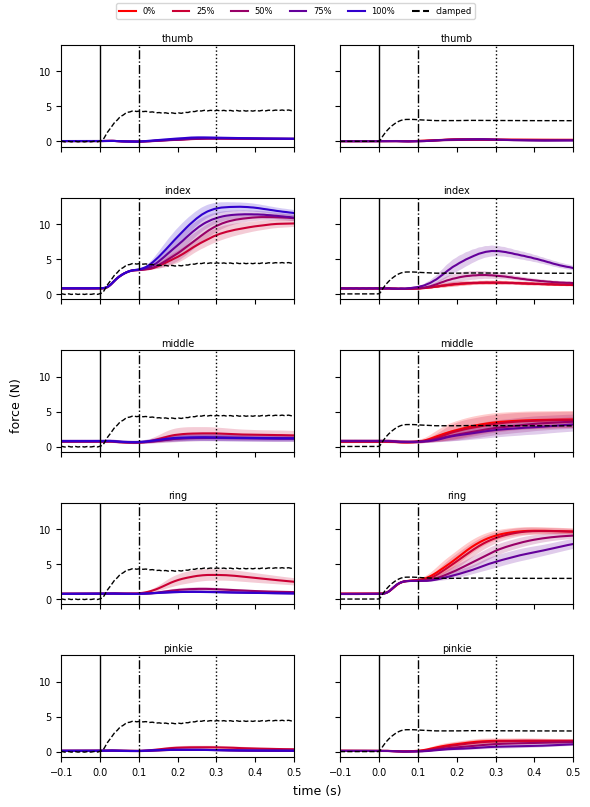

In [9]:
Info_p = Info(
        experiment,
        participants=['100', '101', '102', '103', '104',
                      '105', '106', '107', '108', '110'],
        datatype=datatype,
        condition_headers=['stimFinger', 'cues']
    )

Info_f = Info(
    experiment,
    participants=['100', '101', '102', '103', '104',
                  '105', '106', '107', '108', '110'],
    datatype=datatype,
    condition_headers=['stimFinger']
)

wins = {
    'mov': ((-1, 0),
            (0, .1),
            (.1, .3),
            (.3, 1)),
    'emg': ((-1, 0),
            (0, .05),
            (.05, .1),
            (.1, .3))
}

# define channels to plot for each datatype
channels = {
    'mov': ["thumb", "index", "middle", "ring", "pinkie"],
    'emg': ["thumb_flex", "index_flex", "middle_flex", "ring_flex",
            "pinkie_flex", "thumb_ext", "index_ext",
            "middle_ext", "ring_ext", "pinkie_ext", "fdi"]
}

# define ylabel per datatype
ylabel = {
    'mov': 'force (N)',
    'emg': 'emg (mV)'
}

if plottype == 'con':

    # create list of 3D data (segmented trials)
    Data = list()
    for participant_id in Info_p.participants:
        data = load_npy(Info_p.experiment, participant_id=participant_id, datatype=datatype)
        Data.append(data)

    # create list of participants
    Y = list_participants(Data, Info_p)

    timeAx = Params.timeAx()
    timeAx_c = (timeAx - Clamp.latency[0], timeAx - Clamp.latency[1])

    dict_lims['xlim'] = (-.1, .5)
    dict_text['ylabel'] = ylabel[datatype]
    dict_legend['ncol'] = 6
    dict_vlines['pos'] = [win[1] for win in wins[datatype]]
    dict_vlines['lw'] = [1] * len(wins[datatype])
    dict_vlines['color'] = ['k'] * len(wins[datatype])
    dict_vlines['ls'] = ['-', '-.', ':', '--']

    Plot = Plotter3D(
        xAx=timeAx_c,
        data=Y,
        channels=channels[datatype],
        conditions=['index', 'ring'],
        labels=['0%', '25%', '50%', '75%', '100%'],
        figsize=(6.4, 8),
        lims=dict_lims,
        legend=dict_legend,
        vlines=dict_vlines,
        text=dict_text

    )

    colors = Plot.make_colors()
    Plot.subplots((colors[1:], colors[:4]))
    Plot.set_titles()
    Plot.set_legend(colors)
    Plot.xylabels()
    Plot.set_xyticklabels_size()
    Plot.set_xylim()
    Plot.add_vertical_lines()
    # Plot.fig.set_constrained_layout(True)
    Plot.fig.subplots_adjust(hspace=.5, bottom=.06, top=.95, left=.1, right=.9)

    if datatype == 'mov':
        for row in range(Plot.axs.shape[0]):
            for col in range(Plot.axs.shape[1]):
                Plot.axs[row, col].plot(Clamp.timeAx()[col], Clamp.clamped_f[col],
                                        ls='--', color='k', lw=1)
        Plot.axs[0, 0].plot(np.nan, ls='--', color='k', lw=1)
        add_entry_to_legend(Plot.fig, label='clamped')

    plt.show()

elif plottype == 'bin':

    wins = wins[datatype]

    Data = list()
    for p, participant_id in enumerate(Info_p.participants):
        data = load_npy(Info_p.experiment, participant_id=participant_id, datatype=datatype)
        Zf = indicator(Info_f.cond_vec[p]).astype(bool)
        bins_i = bin_traces(data[Zf[:, 0]], wins, fsample=Params.fsample,
                            offset=Params.prestim + Clamp.latency[0])
        bins_r = bin_traces(data[Zf[:, 1]], wins, fsample=Params.fsample,
                            offset=Params.prestim + Clamp.latency[1])
        bins = np.concatenate((bins_i, bins_r), axis=0)
        Info_p.cond_vec[p] = np.concatenate((Info_p.cond_vec[p][Zf[:, 0]], Info_p.cond_vec[p][Zf[:, 1]]),
                                            axis=0).astype(int)
        Data.append(bins)

    # create list of participants
    Y = list_participants(Data, Info_p)

    xAx = np.linspace(0, 3, 4)

    dict_lims['xlim'] = (-1, 4)
    dict_text['xlabel'] = None
    dict_text['ylabel'] = ylabel[datatype]
    dict_text['xticklabels'] = [f"{win[0]}s to {win[1]}s" for win in wins]

    Anov = Anova(
        data=Y,
        channels=channels[datatype],
        conditions=['index', 'ring'],
        labels=['0%', '25%', '50%', '75%', '100%']
    )

    Plot = Plotter3D(
        xAx=(xAx, xAx),
        data=Y,
        channels=channels[datatype],
        conditions=['index', 'ring'],
        labels=['0%', '25%', '50%', '75%', '100%'],
        lims=dict_lims,
        text=dict_text,
        bar=dict_bars,
        figsize=(6.4, 8),
        plotstyle='bar'
    )

    colors = Plot.make_colors()
    Plot.subplots((colors[1:], colors[:4]))
    Plot.set_titles()
    Plot.set_legend(colors)
    Plot.xylabels()
    Plot.set_xylim()
    Plot.set_xyticklabels_size()
    Plot.set_xticklabels()
    # Plot.fig.set_constrained_layout(True)
    Plot.fig.subplots_adjust(hspace=.5, bottom=.08, top=.95, left=.1, right=.9)
    plt.show()
